In [6]:
from IPython.display import display, clear_output
import keyboard
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ['cmr10'],
    "axes.labelsize": 22, 
    "axes.titlesize": 25, 
    "xtick.labelsize": 22, 
    "ytick.labelsize": 22, 
    "legend.fontsize": 20,
    "figure.figsize": [12, 7], 
    "figure.dpi": 300 
})
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from keras.constraints import NonNeg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

In [7]:
def S21 (w, k, kc, Omega, DeltaE, gamma, g):
    up = kc
    down = (Omega-w) - 1j * k - 1j * g**2 / (1j * (DeltaE - w) + gamma)
    t = 1 - up / (1j * down)
    return np.abs(t)

Omega = 2.116451
gamma = 6.5e-3

In [8]:
# Definimos una función que genere la base de datos
def Parameters_generator (num_datos):
    k = np.random.uniform(1e-4, 1e-3, num_datos)
    kc = np.random.uniform(1e-5, 1e-4, num_datos)
    g = np.random.uniform(1e-2, 1.5e-2, num_datos)
    DeltaE = np.random.uniform(1.8, 2.4, num_datos)

    return k, kc, g, DeltaE


In [9]:
def Dense_five ():
    model = Sequential()
    model.add(Input(shape=(input_neurons,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32 , activation='relu'))
    model.add(Dense(16 , activation='relu'))
    model.add(Dense(output_neurons, activation='linear', kernel_constraint=NonNeg())) 

    #Compila el modelo
    model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model



In [10]:
# Lista de tamaños de base de datos a probar
num_datos_list = [250, 500, 1000, 2500, 5000, 10000, 25000, 50000, 100000, 150000]

losses = []
training_times = []

#Elegimos los hiperparámetros
batch_size = 250
epochs = 1000

for num_datos in num_datos_list:
    # Generar los datos de la base de datos
    k, kc, g, DeltaE = Parameters_generator(num_datos)
    datos = np.column_stack((k, kc, g))
    w_values = np.linspace(2.09, 2.14, 2500)
    # Crear una matriz para almacenar los t(w)
    t_values = np.zeros((num_datos, len(w_values)))
    t_values_noise = np.zeros((num_datos, len(w_values)))

    for i in range (num_datos):
        t_values[i,:] = S21(w_values, k[i], kc[i], Omega, DeltaE[i], gamma, g[i])

    # Añadir ruido basado en el valor mínimo de cada curva
    min_values = np.min(t_values, axis=1)

    # Inicializar los niveles de ruido
    noise_levels = np.zeros((num_datos, len(w_values)))

    # Ajustar los niveles de ruido
    for i in range(num_datos):
        if min_values[i] > 0.975:
            noise_levels[i, :] = 0.15 * (1 - min_values[i])
        elif min_values[i] > 0.85:
            noise_levels[i, :] = 0.05 * (1 - min_values[i])
        else:
            noise_levels[i, :] = 0.015 * (1 - min_values[i])

    # Crear el ruido y añadirlo a los valores originales
    noise_matrix = np.random.normal(0, noise_levels)
    t_values_noise = t_values + noise_matrix

    #Seleccionamos los datos de entrenamiento y de validación
    indices = np.arange(num_datos)
    indices_train, indices_post = train_test_split(indices, test_size=0.2)
    indices_val, indices_test = train_test_split(indices_post, test_size=0.5)

    x_train = t_values_noise[indices_train]
    x_val = t_values_noise[indices_val]
    x_test = t_values_noise[indices_test]
    y_train = datos[indices_train]
    y_val = datos[indices_val]
    y_test = datos[indices_test]
    
    # Normalizamos los datos
    scaler_x = RobustScaler()
    x_train_norm = scaler_x.fit_transform(x_train)
    x_val_norm = scaler_x.transform(x_val)
    x_test_norm = scaler_x.transform(x_test)

    scaler_y = RobustScaler()
    y_train_norm = scaler_y.fit_transform(y_train)
    y_val_norm = scaler_y.transform(y_val)
    y_test_norm = scaler_y.transform(y_test)
    
    #Número de neuronas de entrada y salida
    input_neurons  = x_train.shape[1]
    output_neurons = y_train.shape[1]

    # Definir y compilar el modelo
    model = Dense_five()
    
    # Entrenar el modelo y registrar el tiempo de entrenamiento
    start_time = time.time()
    history = model.fit(x_train_norm, y_train_norm, batch_size=batch_size, validation_data=(x_val_norm, y_val_norm),
                        epochs=epochs, verbose=2)
    end_time = time.time()
    training_time = end_time - start_time
    training_times.append(training_time)
    
    # Evaluar el modelo en los datos de validación
    scores = model.evaluate(x_test_norm, y_test_norm, verbose=0)
    final_loss = scores[0]
    losses.append(final_loss) 

np.savetxt('losses_datasize.txt', losses)
np.savetxt('training_times_datasize.txt', training_times)

Epoch 1/1000
1/1 - 2s - 2s/step - loss: 0.5842 - mean_absolute_error: 0.6244 - val_loss: 0.3875 - val_mean_absolute_error: 0.5055
Epoch 2/1000
1/1 - 0s - 48ms/step - loss: 0.3717 - mean_absolute_error: 0.5082 - val_loss: 0.3716 - val_mean_absolute_error: 0.5165
Epoch 3/1000
1/1 - 0s - 48ms/step - loss: 0.3278 - mean_absolute_error: 0.4804 - val_loss: 0.3671 - val_mean_absolute_error: 0.5166
Epoch 4/1000
1/1 - 0s - 48ms/step - loss: 0.3005 - mean_absolute_error: 0.4591 - val_loss: 0.3599 - val_mean_absolute_error: 0.5099
Epoch 5/1000
1/1 - 0s - 48ms/step - loss: 0.2810 - mean_absolute_error: 0.4413 - val_loss: 0.3551 - val_mean_absolute_error: 0.5062
Epoch 6/1000
1/1 - 0s - 49ms/step - loss: 0.2672 - mean_absolute_error: 0.4270 - val_loss: 0.3547 - val_mean_absolute_error: 0.5059
Epoch 7/1000
1/1 - 0s - 48ms/step - loss: 0.2573 - mean_absolute_error: 0.4182 - val_loss: 0.3568 - val_mean_absolute_error: 0.5064
Epoch 8/1000
1/1 - 0s - 47ms/step - loss: 0.2492 - mean_absolute_error: 0.4105

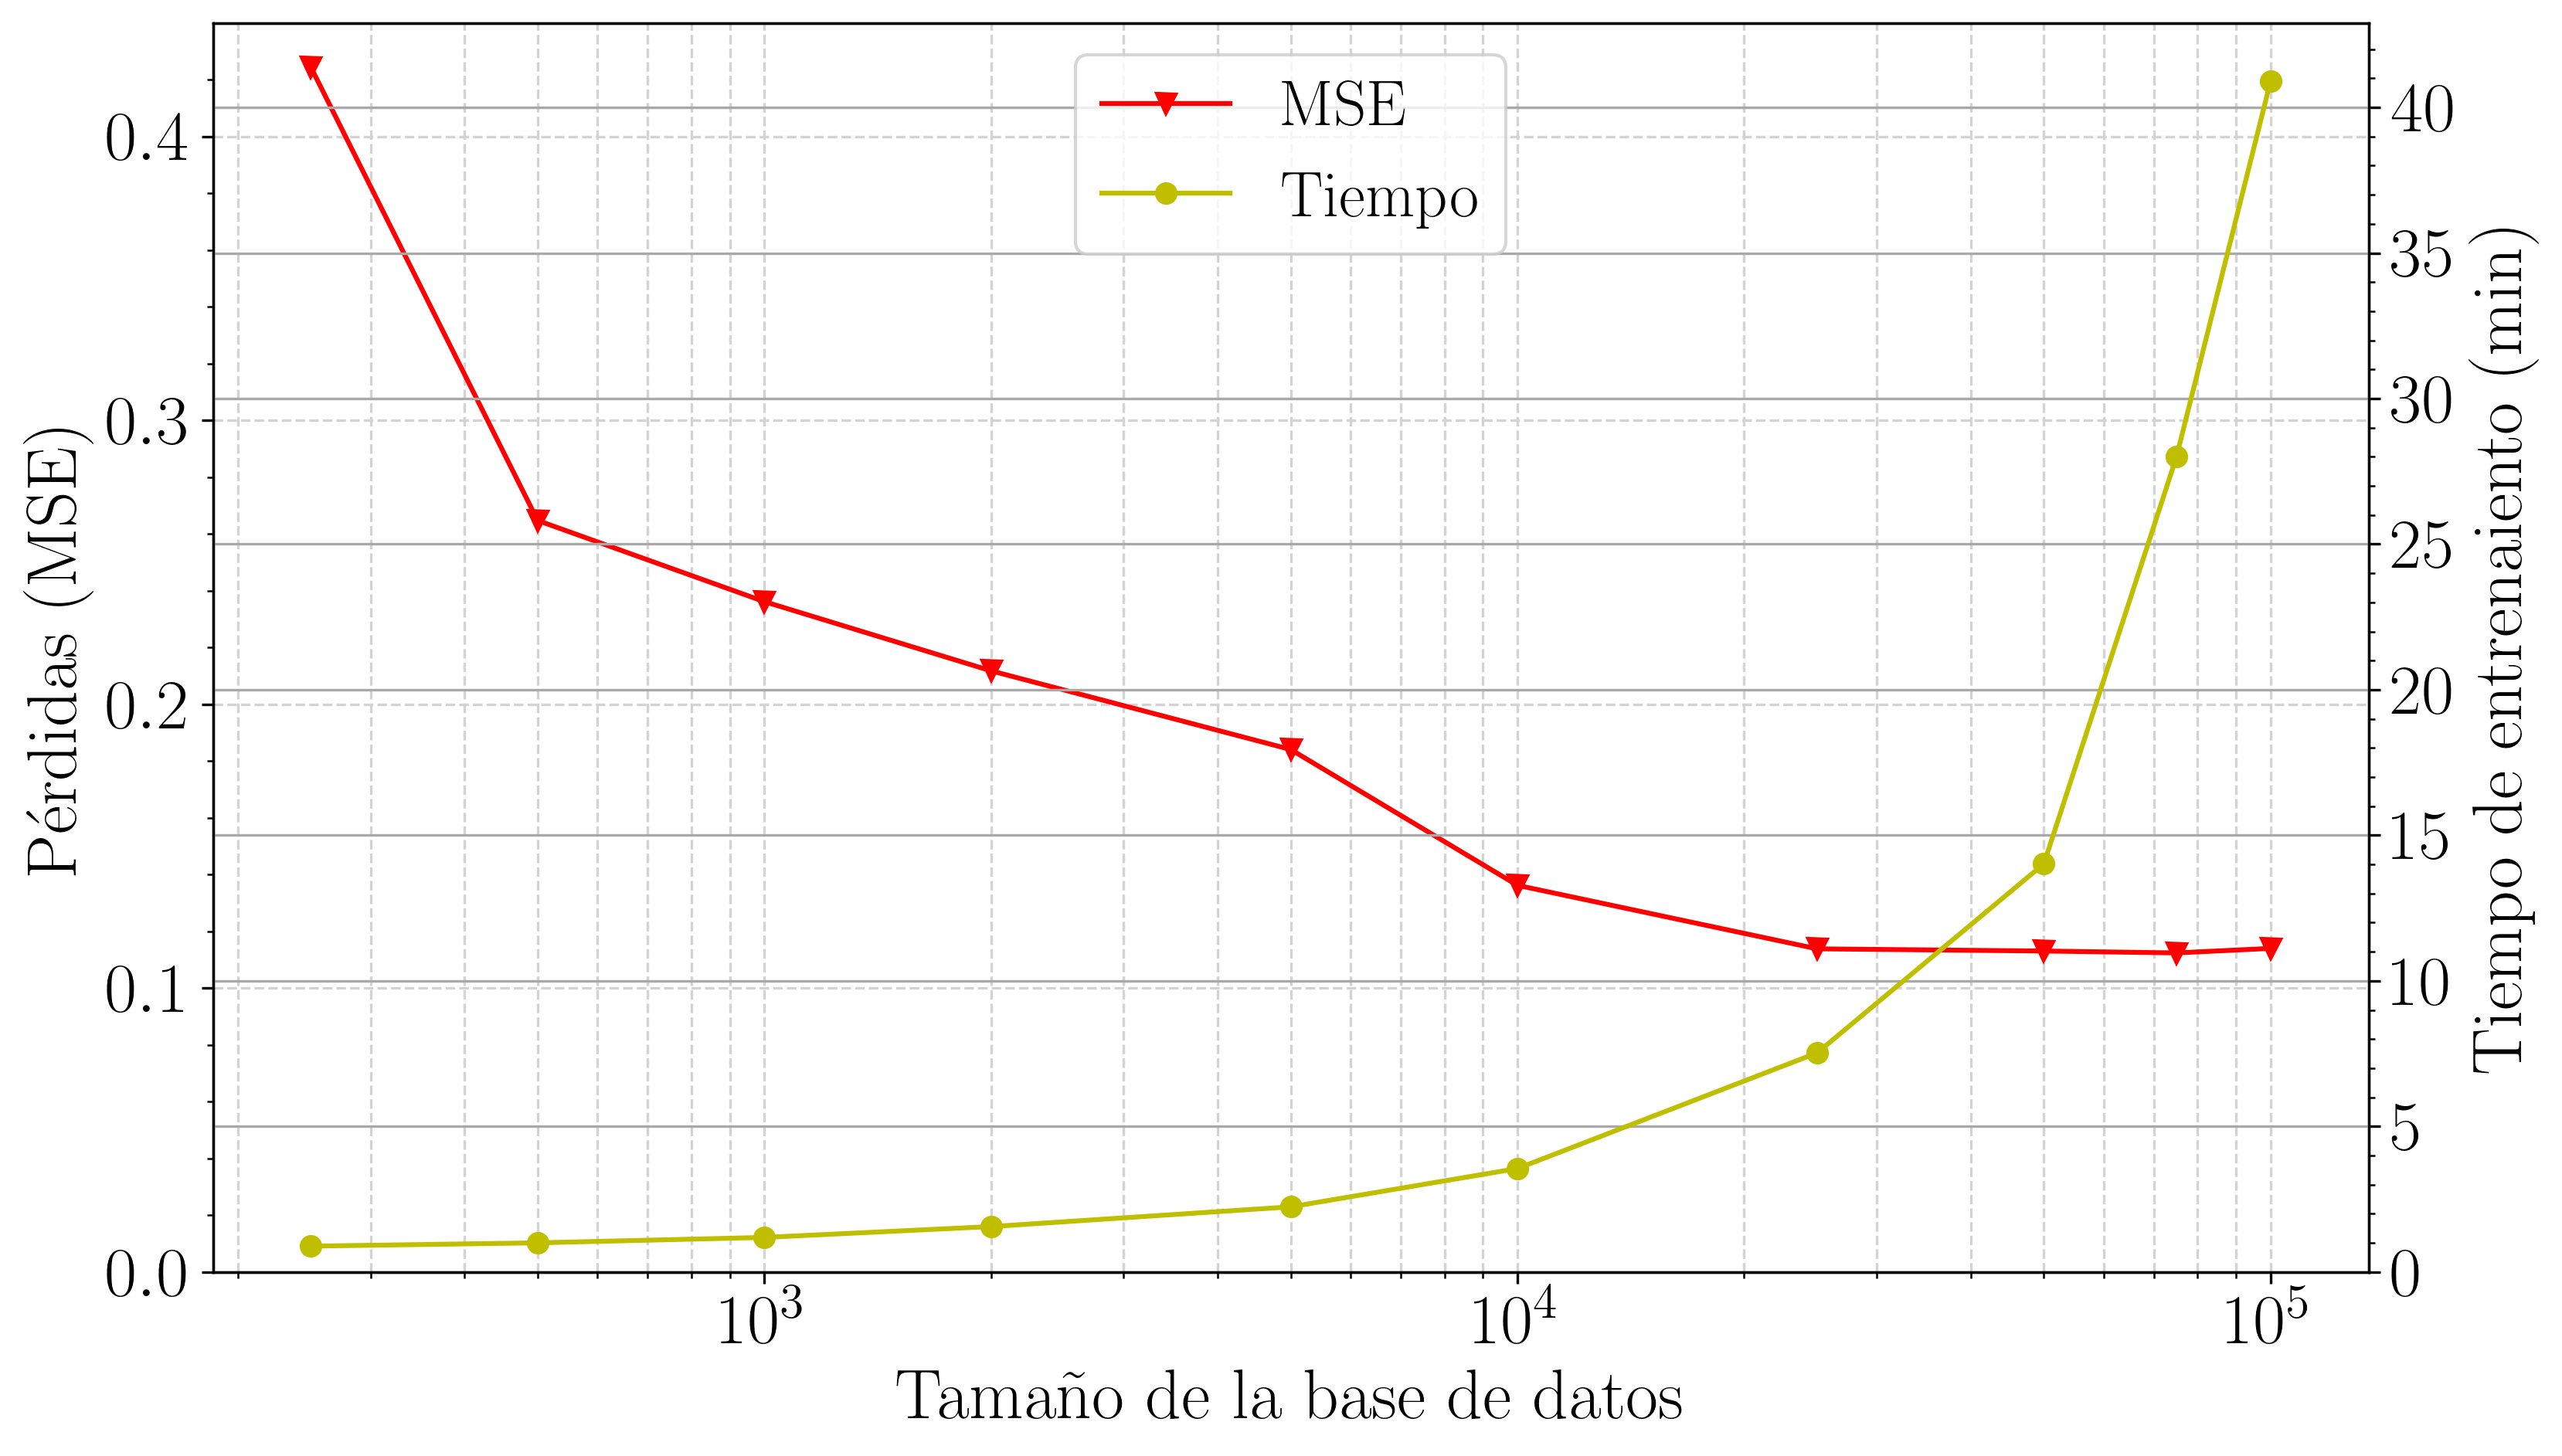

In [18]:
losses = np.loadtxt('losses_datasize.txt')
training_times = np.loadtxt('training_times_datasize.txt')

# Convertir los tiempos de entrenamiento de segundos a minutos
training_times_minutes = training_times / 60.0

# Lista de tamaños de base de datos a probar
num_datos_list = [250, 500, 1000, 2000, 5000, 10000, 25000, 50000, 75000, 100000]

# y_ticks = [i/50 for i in range(int(min(losses)*50), int((max(losses)*50+2)), 5)]
plt.xlabel('Tamaño de la base de datos')
plt.ylabel('Pérdidas (MSE)')
lns1 = plt.plot(num_datos_list, losses, marker='v', color='r', label='MSE')
# plt.yticks(y_ticks)
plt.minorticks_on()
plt.grid(which='major', color='lightgrey', linestyle='--')
plt.grid(axis='x', which='both', color='lightgrey', linestyle='--')
plt.ylim(0)

plt.twinx()
plt.ylabel('Tiempo de entrenaiento (min)')  
lns2 = plt.plot(num_datos_list, training_times_minutes, marker='o', color='y', label='Tiempo')
yticks = [i for i in range(0, int(max(training_times_minutes))+2, 5)]
plt.yticks(yticks)
plt.ylim(0)

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc='upper center')
plt.xscale('log')
plt.grid(linestyle='-', color='darkgrey')
plt.minorticks_on()

plt.show()